# Microsoft Malware Detection


__Goal:__ Predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. It is really important to find out whether the computer is infected and cure it.




![](https://storage.googleapis.com/kaggle-competitions/kaggle/10683/logos/thumb76_76.png?t=2018-09-19-16-55-15)

In [2]:
# Data Manipulation
import numpy as np 
import pandas as pd 

# Data Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# Track time
import time
import datetime

# Machine Learning
from   sklearn.preprocessing import LabelEncoder
from   sklearn.model_selection import train_test_split, GridSearchCV
from   sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve
from   sklearn.linear_model import LogisticRegression
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier
from   xgboost import XGBClassifier
#from   lightgbm import LGBMClassifier
from   scipy.stats import chi2_contingency, f_oneway


import gc
import warnings
from   tqdm import tqdm_notebook


# Set Options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.style.use('ggplot')
py.init_notebook_mode(connected=False) # To work offline
warnings.filterwarnings("ignore")

##  2. Data Overview

The goal of this section is to :
- Load the malware dataset 
- Explore the features

Load the malware dataset using `pd.read_csv()`. File size is huge, so let's work on half data only i.e. 1000000 rows

In [7]:
%%time
n_rows=1000000
train = pd.read_csv('../malware_df.csv',
                    nrows = n_rows)

CPU times: user 6.37 s, sys: 706 ms, total: 7.08 s
Wall time: 7.15 s


In [8]:
train.sample(5)

MachineIdentifier   ProductName EngineVersion  \
38679   011f45e4ed055e21f95def410102c3fe  win8defender   1.1.15000.2   
168745  04d9bf46a15632ca79aa03563f14ba33  win8defender   1.1.15200.1   
317512  09224bfa8a0aecff771d5e8acf3d45f6  win8defender   1.1.15200.1   
969478  1bd979ec7214b0c54a25f0d3a10a52e2  win8defender   1.1.15200.1   
163421  04b2a43b8bbcbf0ed0d477f9f18f71ba  win8defender   1.1.15200.1   

             AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
38679       4.9.10586.0   1.271.632.0       0               7.0   
168745  4.18.1806.18062  1.275.1765.0       0               7.0   
317512  4.18.1807.18075   1.275.573.0       0               7.0   
969478  4.18.1807.18075  1.275.1176.0       0               7.0   
163421  4.18.1807.18075   1.275.911.0       0               7.0   

        IsSxsPassiveMode  DefaultBrowsersIdentifier  \
38679                  0                        NaN   
168745                 0                        NaN   
317512                 0                        NaN   
969478                 0                        NaN   
163421                 0                        NaN   

        AVProductStatesIdentifier  AVProductsInstalled  AVProductsEnabled  \
38679                      6630.0                  3.0                1.0   
168745                    53447.0                  1.0                1.0   
317512                    53447.0                  1.0                1.0   
969478                    53447.0                  1.0                1.0   
163421                    53447.0                  1.0                1.0   

        HasTpm  CountryIdentifier  CityIdentifier  OrganizationIdentifier  \
38679        1                 68         83494.0                    27.0   
168745       1                 51         51517.0                    27.0   
317512       1                 88         20710.0                     NaN   
969478       1                 25         58351.0                     NaN   
163421       1                 19         20321.0                    27.0   

        GeoNameIdentifier  LocaleEnglishNameIdentifier   Platform Processor  \
38679               276.0                           74  windows10       x64   
168745               98.0                          103  windows10       x86   
317512              117.0                          115  windows10       x64   
969478                NaN                           75  windows10       x64   
163421               24.0                           81  windows10       x86   

           OsVer  OsBuild  OsSuite OsPlatformSubRelease  \
38679   10.0.0.0    10586      768                  th2   
168745  10.0.0.0    14393      768                  rs1   
317512  10.0.0.0    17134      256                  rs4   
969478  10.0.0.0    14393      768                  rs1   
163421  10.0.0.0    16299      256                  rs3   

                                         OsBuildLab SkuEdition  IsProtected  \
38679      10586.0.amd64fre.th2_release.151029-1700       Home          1.0   
168745    14393.2363.x86fre.rs1_release.180625-1741       Home          1.0   
317512     17134.1.amd64fre.rs4_release.180410-1804        Pro          1.0   
969478  14393.2189.amd64fre.rs1_release.180329-1711       Home          1.0   
163421      16299.15.x86fre.rs3_release.170928-1534        Pro          1.0   

        AutoSampleOptIn PuaMode  SMode  IeVerIdentifier   SmartScreen  \
38679                 0     NaN    0.0             71.0  RequireAdmin   
168745                0     NaN    0.0             98.0  RequireAdmin   
317512                0     NaN    0.0            137.0           NaN   
969478                0     NaN    0.0             98.0  RequireAdmin   
163421                0     NaN    0.0            117.0  RequireAdmin   

        Firewall  UacLuaenable Census_MDC2FormFactor Census_DeviceFamily  \
38679        1.0           1.0              Notebook     Windows.Desktop   
168745       1.0           1.0    

### Data Description

The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. 


The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.
Columns


Unavailable or self-documenting column names are marked with an "NA".
1.	__MachineIdentifier__ - Individual machine ID
2.	__ProductName__ - Defender state information e.g. win8defender
3.	__EngineVersion__ - Defender state information e.g. 1.1.12603.0
4.	__AppVersion__ - Defender state information e.g. 4.9.10586.0
5.	__AvSigVersion__ - Defender state information e.g. 1.217.1014.0
6.	__IsBeta__ - Defender state information e.g. false
7.	__RtpStateBitfield__ - NA
8.	__IsSxsPassiveMode__ - NA
9.	__DefaultBrowsersIdentifier__ - ID for the machine's default browser
10.	__AVProductStatesIdentifier__ - ID for the specific configuration of a user's antivirus software
11.	__AVProductsInstalled__ - NA
12.	__AVProductsEnabled__ - NA
13.	__HasTpm__ - True if machine has tpm
14.	__CountryIdentifier__ - ID for the country the machine is located in
15.	__CityIdentifier__ - ID for the city the machine is located in
16.	__OrganizationIdentifier__ - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
17.	__GeoNameIdentifier__ - ID for the geographic region a machine is located in
18.	__LocaleEnglishNameIdentifier__ - English name of Locale ID of the current user
19.	__Platform__ - Calculates platform name (of OS related properties and processor property)
20.	__Processor__ - This is the process architecture of the installed operating system
21.	__OsVer__ - Version of the current operating system
22.	__OsBuild__ - Build of the current operating system
23.	__OsSuite__ - Product suite mask for the current operating system.
24.	__OsPlatformSubRelease__ - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
25.	__OsBuildLab__ - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
26.	__SkuEdition__ - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.
27.	__IsProtected__ - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
28.	__AutoSampleOptIn__ - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9+
29.	__PuaMode__ - Pua Enabled mode from the service
30.	__SMode__ - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
31.	__IeVerIdentifier__ - NA
32.	__SmartScreen__ - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.
33.	__Firewall__ - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
34.	__UacLuaenable__ - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.
35.	vCensus_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible…)
36.	__Census_DeviceFamily__ - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
37.	__Census_OEMNameIdentifier__ - NA
38.	__Census_OEMModelIdentifier__ - NA
39.	__Census_ProcessorCoreCount__ - Number of logical cores in the processor
40.	__Census_ProcessorManufacturerIdentifier__ - NA
41.	__Census_ProcessorModelIdentifier__ - NA
42.	__Census_ProcessorClass__ - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
43.	__Census_PrimaryDiskTotalCapacity__ - Amount of disk space on primary disk of the machine in MB
44.	__Census_PrimaryDiskTypeName__ - Friendly name of Primary Disk Type - HDD or SSD
45.	__Census_SystemVolumeTotalCapacity__ - The size of the partition that the System volume is installed on in MB
46.	__Census_HasOpticalDiskDrive__ - True indicates that the machine has an optical disk drive (CD/DVD)
47.	__Census_TotalPhysicalRAM__ - Retrieves the physical RAM in MB
48.	__Census_ChassisTypeName__ - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
49.	__Census_InternalPrimaryDiagonalDisplaySizeInInches__ - Retrieves the physical diagonal length in inches of the primary display
50.	__Census_InternalPrimaryDisplayResolutionHorizontal__ - Retrieves the number of pixels in the horizontal direction of the internal display.
51.	__Census_InternalPrimaryDisplayResolutionVertical__ - Retrieves the number of pixels in the vertical direction of the internal display
52.	__Census_PowerPlatformRoleName__ - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
53.	__Census_InternalBatteryType__ - NA
54.	__Census_InternalBatteryNumberOfCharges__ - NA
55.	__Census_OSVersion__ - Numeric OS version Example - 10.0.10130.0
56.	__Census_OSArchitecture__ - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
57.	__Census_OSBranch__ - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fblpartnereeap where OsVersion = 6.4.9813.0.amd64fre.fblpartnereeap.140810-0005
58.	__Census_OSBuildNumber__ - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
59.	__Census_OSBuildRevision__ - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
60.	__Census_OSEdition__ - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
61.	__Census_OSSkuName__ - OS edition friendly name (currently Windows only)
62.	__Census_OSInstallTypeName__ - Friendly description of what install was used on the machine i.e. clean
63.	__Census_OSInstallLanguageIdentifie_r__ - NA
64.	__Census_OSUILocaleIdentifier__ - NA
65.	__Census_OSWUAutoUpdateOptionsName__ - Friendly name of the WindowsUpdate auto-update settings on the machine.
66.	__Census_IsPortableOperatingSystem__ - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
67.	__Census_GenuineStateName__ - Friendly name of OSGenuineStateID. 0 = Genuine
68.	__Census_ActivationChannel__ - Retail license key or Volume license key for a machine.
69.	__Census_IsFlightingInternal__ - NA
70.	__Census_IsFlightsDisabled__ - Indicates if the machine is participating in flighting.
71.	__Census_FlightRing__ - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
72.	__Census_ThresholdOptIn__ - NA
73.	__Census_FirmwareManufacturerIdentifier__ - NA
74.	__Census_FirmwareVersionIdentifier__ - NA
75.	__Census_IsSecureBootEnabled__ - Indicates if Secure Boot mode is enabled.
76.	__Census_IsWIMBootEnabled__ - NA
77.	__Census_IsVirtualDevice__ - Identifies a Virtual Machine (machine learning model)
78.	__Census_IsTouchEnabled__ - Is this a touch device ?
79.	__Census_IsPenCapable__ - Is the device capable of pen input ?
80.	__Census_IsAlwaysOnAlwaysConnectedCapable__ - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .
81.	__Wdft_IsGamer__ - Indicates whether the device is a gamer device or not based on its hardware combination.
82.	__Wdft_RegionIdentifier__ - NA




##  3. Optimize Memory Used by Data

In [11]:
train.memory_usage(deep=True).sum()/1024**2

2238.983452796936

In [12]:
train.dtypes

MachineIdentifier                                     object
ProductName                                           object
EngineVersion                                         object
AppVersion                                            object
AvSigVersion                                          object
IsBeta                                                 int64
RtpStateBitfield                                     float64
IsSxsPassiveMode                                       int64
DefaultBrowsersIdentifier                            float64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
HasTpm                                                 int64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier       

Certain features occupy more memory than what is needed to store them. Reducing the memory usage by changing data type will speed up the computations.

Let's create a function for that:

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255
- bool : consumes 1 byte, true or false
- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535
- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647
- float64 / int64 / uint64: consumes 8 bytes of memory

In [20]:
# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
#reduce the memory size of the dataframe
train=reduce_mem_usage(train)

Mem. usage decreased to 1943.34 Mb (13.2% reduction)


##  4. Understand the Data

Before attempting to solve the problem, it's very important to have a good understanding of data.

The goal of this section is to:
- Get the dimensions of data
- Get the summary of data
- Get various statistics of data

In [22]:
#shape of the dataframe
train.shape

(1000000, 83)

In [24]:
#summary of dataframe
train.describe()

IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
count  1000000.000000          996334.0    1000000.000000   
mean         0.000007               NaN          0.017332   
std          0.002646               0.0          0.130505   
min          0.000000               0.0          0.000000   
25%          0.000000               7.0          0.000000   
50%          0.000000               7.0          0.000000   
75%          0.000000               7.0          0.000000   
max          1.000000               8.0          1.000000   

       DefaultBrowsersIdentifier  AVProductStatesIdentifier  \
count                    48303.0              995907.000000   
mean                         inf               47771.191406   
std                          inf               14039.583008   
min                          1.0                   6.000000   
25%                        788.0               49480.000000   
50%                       1632.0               53447.000000   
75%                       2388.0               53447.000000   
max                       3204.0               70492.000000   

       AVProductsInstalled  AVProductsEnabled          HasTpm  \
count             995907.0           995907.0  1000000.000000   
mean                   NaN                NaN        0.987898   
std                    0.0                0.0        0.109341   
min                    1.0                0.0        0.000000   
25%                    1.0                1.0        1.000000   
50%                    1.0                1.0        1.000000   
75%                    2.0                1.0        1.000000   
max                    5.0                5.0        1.000000   

       CountryIdentifier  CityIdentifier  OrganizationIdentifier  \
count     1000000.000000   963487.000000                691064.0   
mean          108.030204    81290.578125                     NaN   
std            63.018707    48946.687500                     0.0   
min             1.000000        5.000000                     1.0   
25%            51.000000    36825.000000                    18.0   
50%            97.000000    82373.000000                    27.0   
75%           162.000000   123984.000000                    27.0   
max           222.000000   167962.000000                    52.0   

       GeoNameIdentifier  LocaleEnglishNameIdentifier         OsBuild  \
count           999981.0               1000000.000000  1000000.000000   
mean                 NaN                   122.882669    15720.202730   
std                  NaN                    69.378930     2189.953705   
min                  1.0                     1.000000     7600.000000   
25%                 89.0                    74.000000    15063.000000   
50%                181.0                    88.000000    16299.000000   
75%                267.0                   182.000000    17134.000000   
max                296.0                   283.000000    18242.000000   

              OsSuite  IsProtected  AutoSampleOptIn          SMode  \
count  1000000.000000     995924.0   1000000.000000  940098.000000   
mean       575.331864          NaN         0.000031       0.000437   
std        248.040450          0.0         0.005568       0.020905   
min         16.000000          0.0         0.000000       0.000000   
25%        256.000000          1.0         0.000000       0.000000   
50%        768.000000          1.0         0.000000       0.000000   
75%        768.000000          1.0         0.000000       0.000000   
max        784.000000          1.0         1.000000       1.000000   

       IeVerIdentifier  Firewall  UacLuaenable  Census_OEMNameIdentifier  \
count         993347.0  989660.0  9.987820e+05                  989473.0   
mean               NaN       NaN  1.372458e+01                       NaN   
std                NaN       0.0  8.995714e+03                       NaN   
min                1.0       0.0  0.000000e+00                       1.0   
25%              111.0       

Some columns have missing values, lets look at the distribution of missing values by column and few more stats

In [25]:
# Stats of dataframe
stats    = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

Feature  Unique_values  \
28                                            PuaMode              1   
41                              Census_ProcessorClass              3   
8                           DefaultBrowsersIdentifier            729   
68                         Census_IsFlightingInternal              2   
52                         Census_InternalBatteryType             36   
71                              Census_ThresholdOptIn              2   
75                            Census_IsWIMBootEnabled              1   
31                                        SmartScreen             13   
15                             OrganizationIdentifier             46   
29                                              SMode              2   
14                                     CityIdentifier          50872   
80                                       Wdft_IsGamer              2   
81                              Wdft_RegionIdentifier             15   
53              Census_InternalBatteryNumberOfCharges           8804   
72              Census_FirmwareManufacturerIdentifier            382   
73                   Census_FirmwareVersionIdentifier          29161   
69                           Census_IsFlightsDisabled              2   
37                          Census_OEMModelIdentifier          59913   
36                           Census_OEMNameIdentifier           1546   
32                                           Firewall              2   
46                            Census_TotalPhysicalRAM            882   
79            Census_IsAlwaysOnAlwaysConnectedCapable              2   
62                 Census_OSInstallLanguageIdentifier             39   
30                                    IeVerIdentifier            209   
42                    Census_PrimaryDiskTotalCapacity           1633   
44                   Census_SystemVolumeTotalCapacity         212928   
48  Census_InternalPrimaryDiagonalDisplaySizeInInches            565   
49  Census_InternalPrimaryDisplayResolutionHorizontal            763   
50    Census_InternalPrimaryDisplayResolutionVertical            748   
40                    Census_ProcessorModelIdentifier           1972   
39             Census_ProcessorManufacturerIdentifier              4   
38                          Census_ProcessorCoreCount             28   
9                           AVProductStatesIdentifier           8192   
10                                AVProductsInstalled              5   
11                                  AVProductsEnabled              6   
26                                        IsProtected              2   
6                                    RtpStateBitfield              6   
76                             Census_IsVirtualDevice              2   
43                         Census_PrimaryDiskTypeName              4   
33                                       UacLuaenable              6   
47                             Census_ChassisTypeName             38   
16                                  GeoNameIdentifier            272   
51                       Census_PowerPlatformRoleName             10   
24                                         OsBuildLab            509   
61                           Census_OSInstallTypeName              9   
60                                   Census_OSSkuName             24   
64                   Census_OSWUAutoUpdateOptionsName              6   
63                        Census_OSUILocaleIdentifier            104   
65                   Census_IsPortableOperatingSystem              2   
78                                Census_IsPenCapable              2   
58                             Census_OSBuildRevision            243   
66                            Census_GenuineStateName              4   
67                           Census_ActivationChannel              6   
77                              Census_IsTouchEnabled              2   
70                                  Census_FlightRing              7   
74            

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>


Lot of interesting things can be observed here:
* `PuaMode` and `Census_ProcessorClass` have 99%+ missing values,  which means that these columns are probably not helpful. So let's drop it for now;
* In `DefaultBrowsersIdentifier` column 95% values belong to one category, this columns is probably also not helpful;
* There are 26 columns in total in which one category contains 90% values. These imbalanced columns may optionally be removed from the dataset;
* Few columns like `Census_IsWIMBootEnabled` don't have any variance. These columns can to dropped.
* One more important point is that there are many columns which are considered to be numerical, but probably they are categorical - like `CityIdentifier`. Let's see more in further steps;



## 5. Data Preprocessing for EDA

The goal of this section is to:
- Drop columns based on the inferences from previous section
- Define the data type for categorical columns

In [26]:
#initial shape
train.shape

(1000000, 83)

In [27]:
# Drop the columns which have more than 90% values missing
good_cols = list(train.columns)
for col in train.columns:
    missing_share = train[col].isnull().sum()/train.shape[0]
    if missing_share > 0.9:
        good_cols.remove(col)
        print("Removed: ", col)

Removed:  DefaultBrowsersIdentifier
Removed:  PuaMode
Removed:  Census_ProcessorClass


In [28]:
#drop the columns where one category contains more than 90% values
for col in good_cols:
    rate=train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print('Removed: ', col)

Removed:  ProductName
Removed:  IsBeta
Removed:  IsSxsPassiveMode
Removed:  AVProductsEnabled
Removed:  Platform
Removed:  OsVer
Removed:  IsProtected
Removed:  SMode
Removed:  Firewall
Removed:  Census_DeviceFamily
Removed:  Census_HasOpticalDiskDrive
Removed:  Census_OSArchitecture
Removed:  Census_IsPortableOperatingSystem
Removed:  Census_IsFlightsDisabled
Removed:  Census_IsVirtualDevice
Removed:  Census_IsPenCapable


In [30]:
#drop the value that has only one unique value
for col in good_cols:
    num_unique=train[col].nunique()
    if num_unique==1:
        good_cols.remove(col)
        print('Remove col: ', col)

Remove col:  Census_IsWIMBootEnabled


In [31]:
#filter the data for relevent columns only
train=train[good_cols]

In [32]:
#check shape of dataset
train.shape

(1000000, 63)

In [33]:
#export cleaned_data to make sure it saved
train.to_csv('../malware_df_clean.csv')

###  Define the data type for categorical columns
In practice, among the numerical variables, many corresponds to identifiers. In the current dataset, the truly numerical variables are in fact rare. Below, create a list of the variables which are truly numerical, according the data description.

In [34]:
# Numeric columns
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges',
    'AVProductsInstalled'
]

List down binary variables.They can be treated as numerical by tree based algorithms

In [35]:
#binary columns
binary=[c for c in train.columns if train[c].nunique()==2]

In [36]:
#categorical columns
categorical=[c for c in train.columns if (c not in true_numerical_columns)&(c not in binary)]

## 6. Exploratory data analysis

In [37]:
%%time
train=pd.read_csv('../malware_df_clean.csv')

CPU times: user 5.92 s, sys: 663 ms, total: 6.59 s
Wall time: 6.61 s


In [38]:
train.head()

Unnamed: 0                 MachineIdentifier EngineVersion  \
0           0  0000028988387b115f69f31a3bf04f09   1.1.15100.1   
1           1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4   
2           2  000007905a28d863f6d0d597892cd692   1.1.15100.1   
3           3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1   
4           4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1   

        AppVersion  AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  4.18.1807.18075  1.273.1735.0               7.0                    53447.0   
1     4.13.17134.1    1.263.48.0               7.0                    53447.0   
2  4.18.1807.18075  1.273.1341.0               7.0                    53447.0   
3  4.18.1807.18075  1.273.1527.0               7.0                    53447.0   
4  4.18.1807.18075  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0               35.0                          171   
1                    18.0              119.0                           64   
2                    18.0               64.0                           49   
3                     NaN              117.0                          115   
4                     NaN              277.0                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  AutoSampleOptIn  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro                0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro                0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home                0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro                0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home                0   

   IeVerIdentifier   SmartScreen  UacLuaenable Census_MDC2FormFactor  \
0            137.0           NaN           1.0               Desktop   
1            137.0           NaN           1.0              Notebook   
2            137.0  RequireAdmin           1.0               Desktop   
3            137.0  ExistsNotSet           1.0               Desktop   
4            137.0  RequireAdmin           1.0              Notebook   

   Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0                    2668.0                     9124.0   
1                    2668.0                    91656.0   
2                    4908.0                   317701.0   
3                    1443.0                   275890.0   
4                    1443.0                   331929.0   

   Census_ProcessorCoreCount  Census_ProcessorManufacturerIdentifier  \
0                        4.0                                     5.0   
1                        4.0                                     5.0   
2                        4.0                                     5.0   
3                        4.0                                     5.0   
4                        4.0                                     5.0   

   Census_ProcessorModelIdentifier  Census_PrimaryDiskTotalCapacity  \
0                           2340.0                         476940.0   
1                           2404.0                         476940.0   
2                           1972.0         

In [39]:
train.drop(0, inplace=True)

In [41]:
# Plot proportion of columns by data type using a pie chart
variables = {
    'categorical_columns': len(categorical),
    'binary_columns': len(binary),
    'true_numerical_columns': len(true_numerical_columns)
}

# Plot
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout    = dict(title= "Variable types", height=400, width=800)
fig       = dict(data=[pie_trace], layout=layout)
py.iplot(fig)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Most of the current variables are categories. Depending on the cardinality of each variable, we will treat the columns differently.

### Compute cardinality of categorical columns

In [43]:
# PLot cardinality
cardinality = []
for c in categorical:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])

# Sort
cardinality.sort(key = lambda x:x[1], reverse=False)

# Plot
trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Top few variables having more than 20-30 categories. They seem to be identifiers (eg: city identifier). So let's remove the top few variables, then plot it. 

In [44]:
# Plot Cardinality
cardinality = []
for c in categorical:
    if c == 'MachineIdentifier': continue
    if train[c].nunique() >= 30: 
        print("High cardinality: ", c)
        continue
    cardinality.append([c, train[c].nunique()])

    
# Sort
cardinality.sort(key = lambda x:x[1], reverse=False)


# Plot
trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

High cardinality:  EngineVersion
High cardinality:  AppVersion
High cardinality:  AvSigVersion
High cardinality:  AVProductStatesIdentifier
High cardinality:  CountryIdentifier
High cardinality:  CityIdentifier
High cardinality:  OrganizationIdentifier
High cardinality:  GeoNameIdentifier
High cardinality:  LocaleEnglishNameIdentifier
High cardinality:  OsBuild
High cardinality:  OsBuildLab
High cardinality:  IeVerIdentifier
High cardinality:  Census_OEMNameIdentifier
High cardinality:  Census_OEMModelIdentifier
High cardinality:  Census_ProcessorModelIdentifier
High cardinality:  Census_ChassisTypeName
High cardinality:  Census_InternalBatteryType
High cardinality:  Census_OSVersion
High cardinality:  Census_OSBuildNumber
High cardinality:  Census_OSBuildRevision
High cardinality:  Census_OSInstallLanguageIdentifier
High cardinality:  Census_OSUILocaleIdentifier
High cardinality:  Census_FirmwareManufacturerIdentifier
High cardinality:  Census_FirmwareVersionIdentifier


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

25 variables have high cardinality (more than 30 unique values). During feature engineering, we will treat them differently.


### Check distribution of target variable

In [46]:
#get count of target class
train['HasDetections'].value_counts()

0    500186
1    499813
Name: HasDetections, dtype: int64

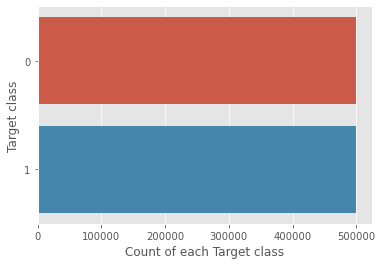

In [47]:
#draw a countplot to check the distribution of the target variable
sns.countplot(y=train['HasDetections'], data=train)
plt.xlabel('Count of each Target class')
plt.ylabel('Target class')
plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

The target variable is **balanced**, which is nice.


### Check Correlations

Lets plot a correlation matrix to check correlation between variables. Each cell in the matrix shows the correlation between two variables.

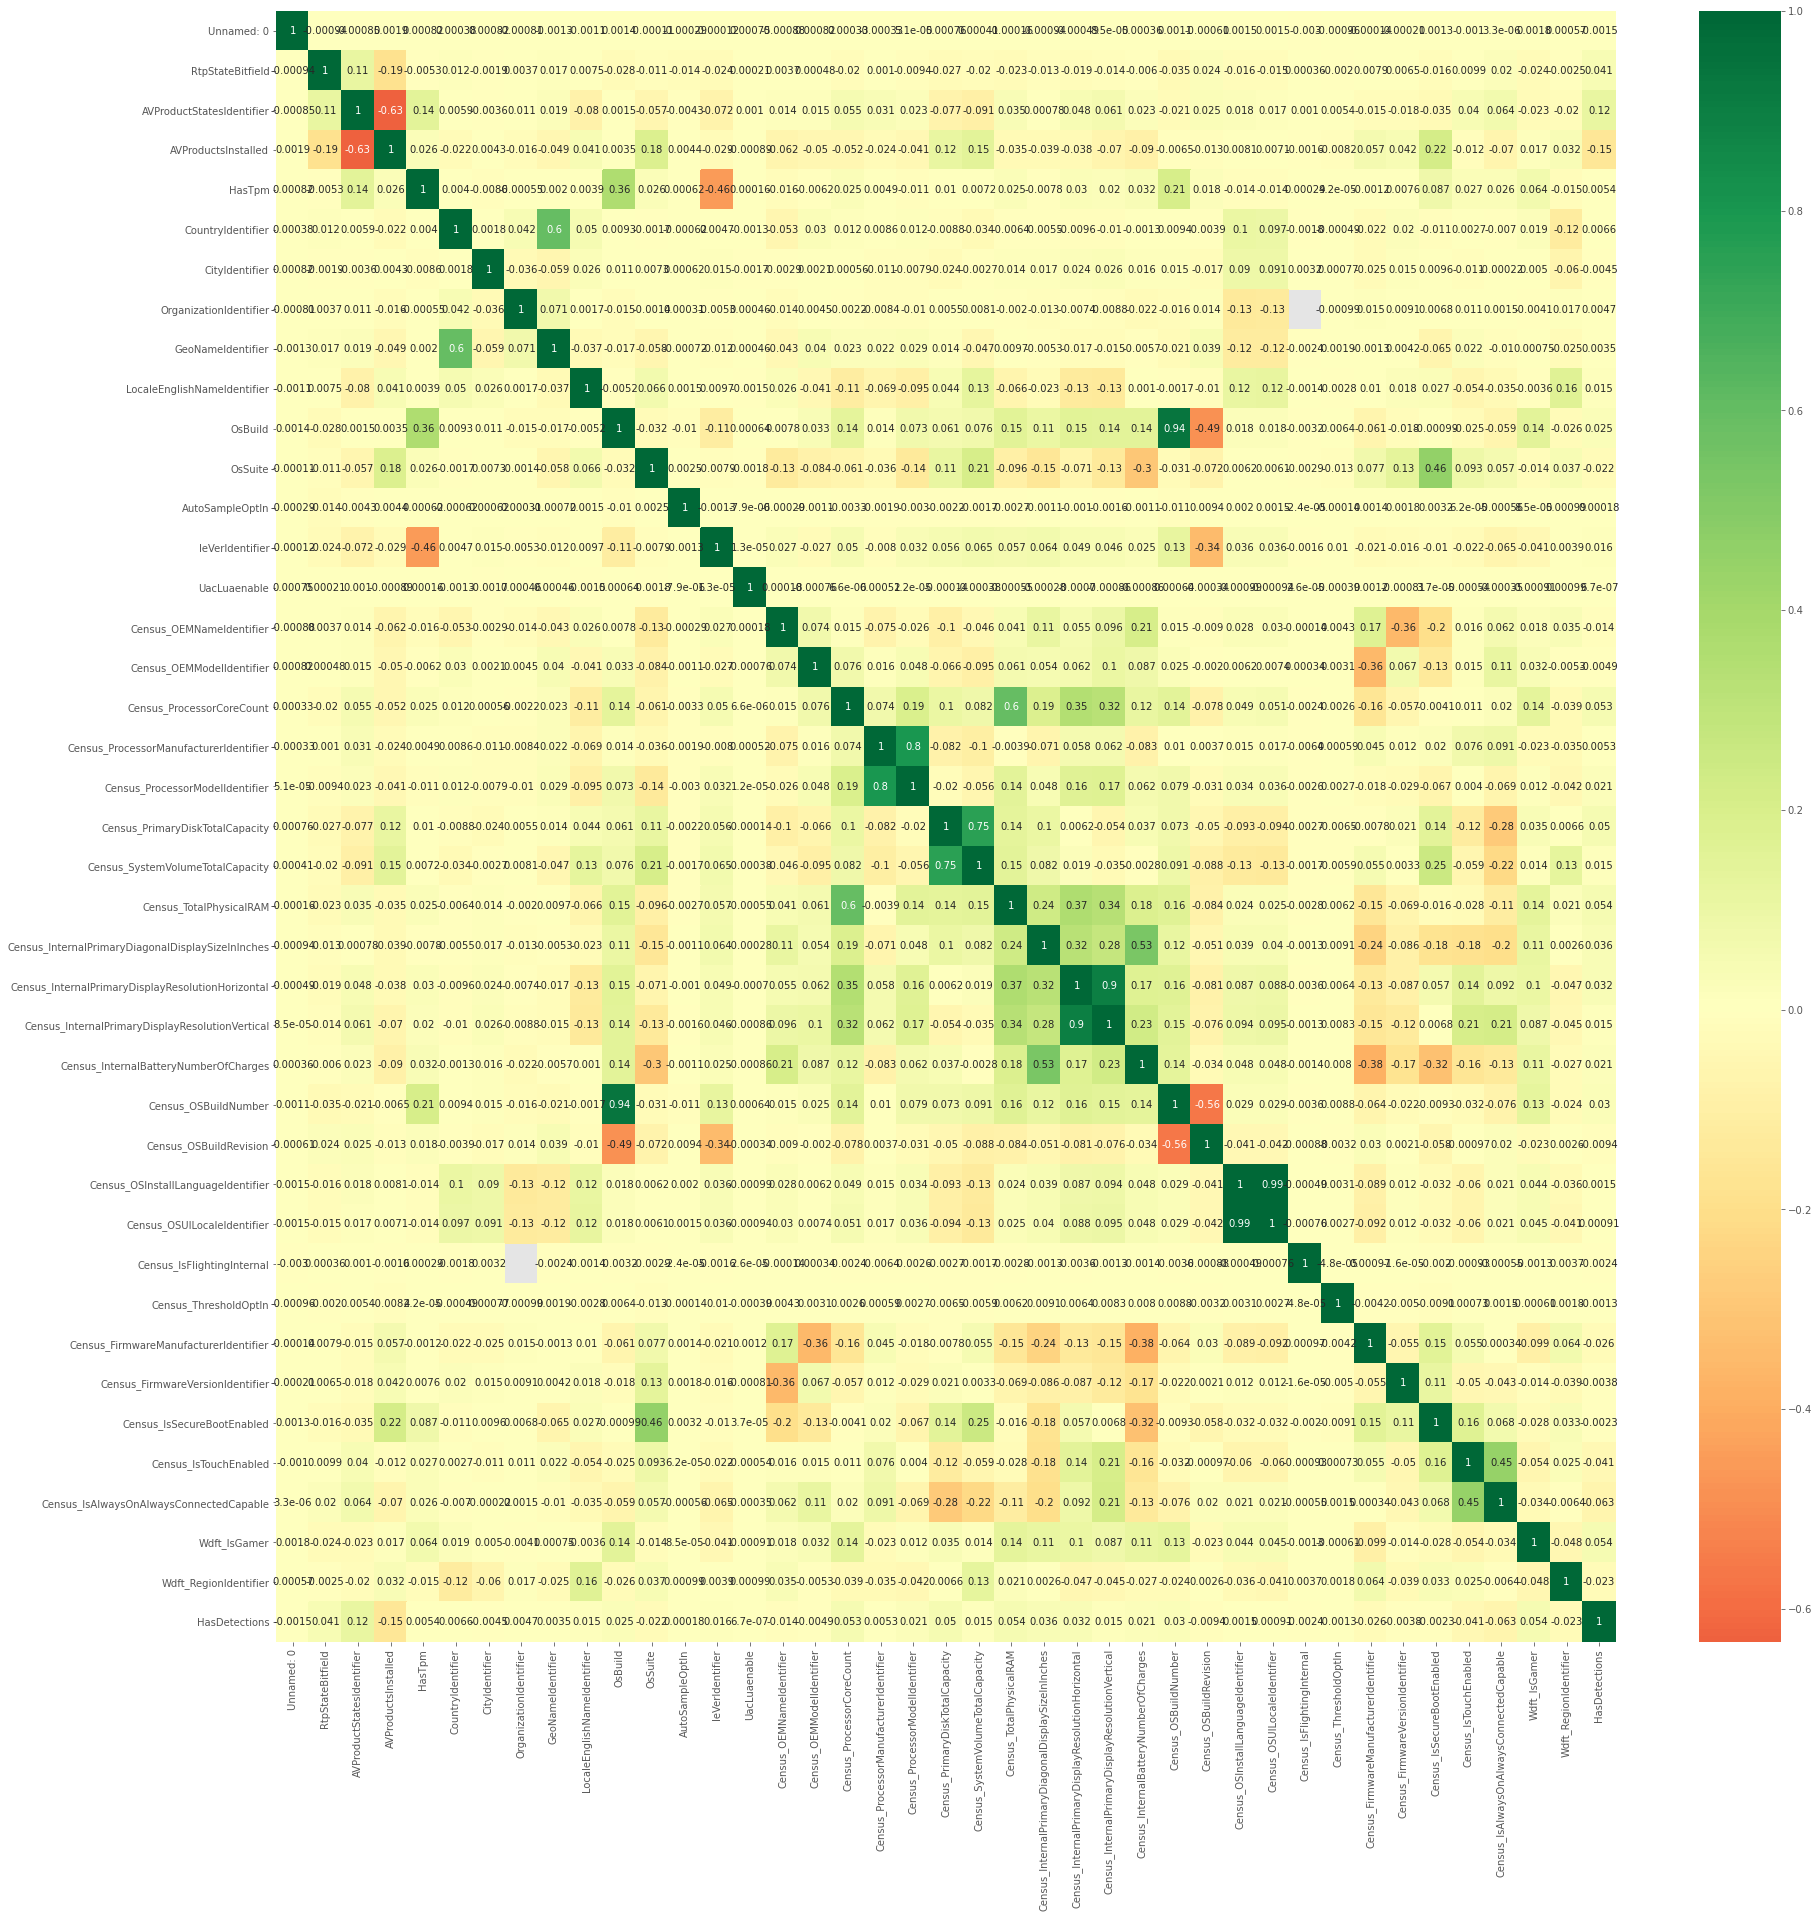

In [49]:
#lets check correlations between all variables
plt.figure(figsize=(30,30))
p=sns.heatmap(train.corr(), annot=True, cmap='RdYlGn', center=0)

It's time to deep dive in some of the most important variables and understand their relationship with target variable 

##  7. Understand Detection Rates by each Feature

Let's understand few functions first, which would be used in further analysis